# Script 22 Plot de Modelo Numérico + Satélite (Exemplo 3)
Neste terceiro exemplo, vamos plotar mais de um campo de modelo (PSML + Espessura 1000-500 hPa), e também vamos ver como plotar simbolos de alta e baixa pressão.

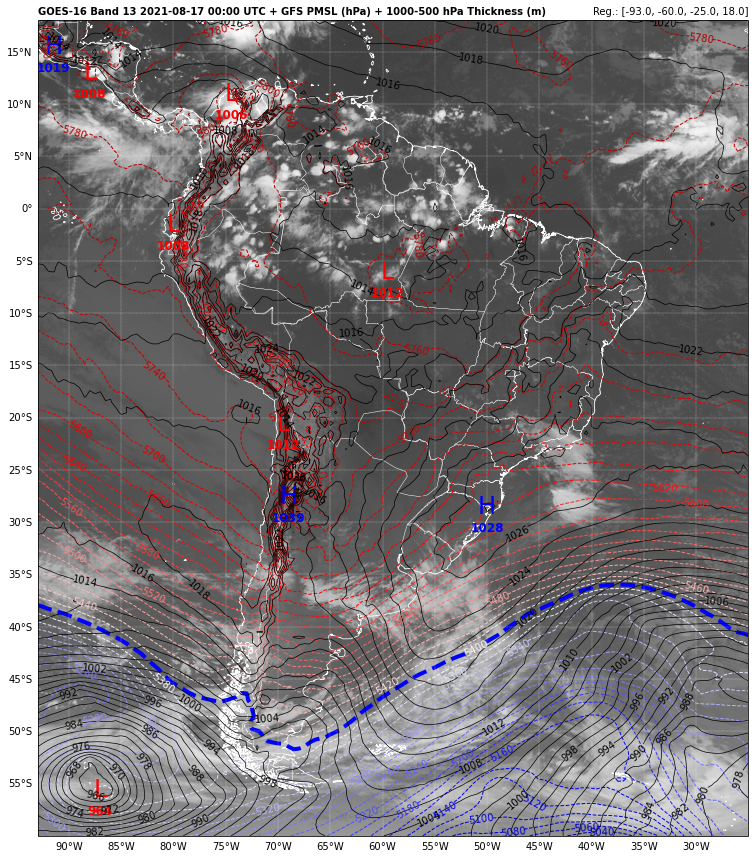

In [1]:
#-----------------------------------------------------------------------------------------------------------
# Curso INPE / CPTEC - Training: Python and GOES-R Imagery: Script 22 - Satellite + NWP Plot (Example 3)
# Instrutor: Diego Souza
# Adaptado: Dejanira F Braz
#-----------------------------------------------------------------------------------------------------------
# Required modules
from netCDF4 import Dataset                         # Read / Write NetCDF4 files
from osgeo import gdal                              # Python bindings for GDAL
import matplotlib.pyplot as plt                     # Plotting library
import cartopy, cartopy.crs as ccrs                 # Plot maps
import cartopy.io.shapereader as shpreader          # Import shapefiles
import os                                           # Miscellaneous operating system interfaces
import numpy as np                                  # Scientific computing with Python
from matplotlib import cm                           # Colormap handling utilities
from datetime import timedelta, date, datetime      # Basic Dates and time types
from utilities import download_CMI                  # Our function for download
from utilities import reproject                     # Our function for reproject
from utilities import loadCPT                       # Import the CPT convert function
import pygrib                                       # Provides a high-level interface to the ECWMF ECCODES C library for reading GRIB files
gdal.PushErrorHandler('CPLQuietErrorHandler')       # Ignore GDAL warnings
#-----------------------------------------------------------------------------------------------------------

def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    """
    This function will find and plot relative maximum and minimum for a 2D grid. The function
    can be used to plot an H for maximum values (e.g., High pressure) and an L for minimum
    values (e.g., low pressue). It is best to used filetered data to obtain  a synoptic scale
    max/min value. The symbol text can be set to a string value and optionally the color of the
    symbol and any plotted value can be set with the parameter color
    lon = plotting longitude values (2D)
    lat = plotting latitude values (2D)
    data = 2D data that you wish to plot the max/min symbol placement
    extrema = Either a value of max for Maximum Values or min for Minimum Values
    nsize = Size of the grid box to filter the max and min values to plot a reasonable number
    symbol = String to be placed at location of max/min value
    color = String matplotlib colorname to plot the symbol (and numerica value, if plotted)
    plot_value = Boolean (True/False) of whether to plot the numeric value of max/min point
    The max/min symbol will be plotted on the current axes within the bounding frame
    (e.g., clip_on=True)
    """
    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == data)

    for i in range(len(mxy)):
         txt1 = ax.annotate(symbol, xy=(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]]), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax), color=color, size=24,
                clip_on=True, annotation_clip=True, horizontalalignment='center', verticalalignment='center',
                transform=ccrs.PlateCarree())
         
         txt2 = ax.annotate('\n' + str(int(data[mxy[i], mxx[i]])), xy=(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]]), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax), 
                color=color, size=12, clip_on=True, annotation_clip=True, fontweight='bold', horizontalalignment='center', verticalalignment='top',
                transform=ccrs.PlateCarree())
      
#-----------------------------------------------------------------------------------------------------------

# Select the extent [min. lon, min. lat, max. lon, max. lat]
extent = [-93.0, -60.00, -25.00, 18.00] 

# Input and output directories
input = "/content/Samples"; os.makedirs(input, exist_ok=True)
output = "/content/Output"; os.makedirs(output, exist_ok=True)

# Datetime to process (today in this example, to match the GFS date)
date = datetime.today().strftime('%Y%m%d')
yyyymmddhhmn = date + '0000'

#-----------------------------------------------------------------------------------------------------------

# Download the ABI file
file_ir = download_CMI(yyyymmddhhmn, 13, input)

#-----------------------------------------------------------------------------------------------------------
# Variable
var = 'CMI'

# Open the file
img = gdal.Open(f'NETCDF:{input}/{file_ir}.nc:' + var)

# Read the header metadata
metadata = img.GetMetadata()
scale = float(metadata.get(var + '#scale_factor'))
offset = float(metadata.get(var + '#add_offset'))
undef = float(metadata.get(var + '#_FillValue'))
dtime = metadata.get('NC_GLOBAL#time_coverage_start')

# Load the data
ds_cmi = img.ReadAsArray(0, 0, img.RasterXSize, img.RasterYSize).astype(float)

# Apply the scale, offset and convert to celsius
ds_cmi = (ds_cmi * scale + offset) - 273.15

# Reproject the file
filename_ret = f'{output}/IR_{yyyymmddhhmn}.nc'
reproject(filename_ret, img, ds_cmi, extent, undef)

# Open the reprojected GOES-R image
file = Dataset(filename_ret)

# Get the pixel values
data = file.variables['Band1'][:]
#----------------------------------------------------------------------------------------------------------- 

# Open the GRIB file
grib = pygrib.open("Samples/gfs.t00z.pgrb2.0p50.f000")
 
# Select the variable
prmls = grib.select(name='Pressure reduced to MSL')[0]

# Get information from the file    
init  = str(prmls.analDate)      # Init date / time
run   = str(prmls.hour).zfill(2) # Run
ftime = str(prmls.forecastTime)  # Forecast hour
valid = str(prmls.validDate)     # Valid date / time 
#print('Init: ' + init + ' UTC')
#print('Run: ' + run + 'Z')
#print('Forecast: +' + ftime)
#print('Valid: ' + valid + ' UTC')

# Read the data for a specific region
prmls, lats, lons = prmls.data(lat1=extent[1],lat2=extent[3],lon1=extent[0]+360,lon2=extent[2]+360)

# Convert to hPa
prmls = prmls / 100

#-----------------------------------------------------------------------------------------------------------

# Select the variable
hght_1000 = grib.select(name='Geopotential Height', typeOfLevel = 'isobaricInhPa', level = 1000)[0]

# Read the data for a specific region
hght_1000 = hght_1000.data(lat1=extent[1],lat2=extent[3],lon1=extent[0]+360,lon2=extent[2]+360)[0]

# Select the variable
hght_500 = grib.select(name='Geopotential Height', typeOfLevel = 'isobaricInhPa', level = 500)[0]

# Read the data for a specific region
hght_500 = hght_500.data(lat1=extent[1],lat2=extent[3],lon1=extent[0]+360,lon2=extent[2]+360)[0]

# Calculate and smooth 1000-500 hPa thickness
thickness_1000_500 = hght_500 - hght_1000

#-----------------------------------------------------------------------------------------------------------

# Choose the plot size (width x height, in inches)
plt.figure(figsize=(15,15))

# Use the Geostationary projection in cartopy
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([extent[0], extent[2], extent[1], extent[3]], ccrs.PlateCarree())

# Define the image extent
img_extent = [extent[0], extent[2], extent[1], extent[3]]

# Define the color scale based on the channel
colormap = "gray_r" # White to black for IR channels
    
# Plot the image
img1 = ax.imshow(data, origin='upper', vmin=-80, vmax=60, extent=img_extent, cmap=colormap, alpha=1.0)

# Define de contour interval
data_min = 4900
data_max = 5900 
interval = 20
levels = np.arange(data_min,data_max,interval)

# Plot the contours   
img2 = ax.contour(lons, lats, thickness_1000_500, cmap='seismic', linestyles='dashed', linewidths=1.0, levels=levels)
ax.clabel(img2, inline=1, inline_spacing=0, fontsize='10',fmt = '%1.0f')#, colors= 'black') # For the labels to have the same colors as the cmap, just omit the "colors" variable

# Get the index of elements with value "5400"
mid_value = int(np.where(levels == 5400)[0])
img2.collections[mid_value].set_linewidth(4)  
img2.collections[mid_value].set_color('blue')

# Define de contour interval
data_min = 500
data_max = 1050
interval = 2
levels = np.arange(data_min,data_max,interval)

# Plot the contours
img3 = ax.contour(lons, lats, prmls, colors='black', linewidths=0.7, levels=levels)
ax.clabel(img3, inline=1, inline_spacing=0, fontsize='10',fmt = '%1.0f', colors= 'black')

# Add a shapefile
# https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/Brasil/BR/br_unidades_da_federacao.zip
shapefile = list(shpreader.Reader('Shapefile/BR_UF_2019.shp').geometries())
ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='white',facecolor='none', linewidth=0.3)

# Add coastlines, borders and gridlines
ax.coastlines(resolution='10m', color='white', linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='white', linewidth=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='white', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 5), ylocs=np.arange(-90, 90, 5), draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Use definition to plot H/L symbols
plot_maxmin_points(lons, lats, prmls, 'max', 50, symbol='H', color='b',  transform=ccrs.PlateCarree())
plot_maxmin_points(lons, lats, prmls, 'min', 25, symbol='L', color='r', transform=ccrs.PlateCarree())

# Extract date
date = (datetime.strptime(dtime, '%Y-%m-%dT%H:%M:%S.%fZ'))

# Add a title
plt.title('GOES-16 Band 13 ' + date.strftime('%Y-%m-%d %H:%M') + ' UTC' + ' + GFS PMSL (hPa) + 1000-500 hPa Thickness (m)', fontweight='bold', fontsize=10, loc='left')
plt.title('Reg.: ' + str(extent) , fontsize=10, loc='right')
#-----------------------------------------------------------------------------------------------------------
# Save the image
plt.savefig(f'{output}/image_22.png', bbox_inches='tight', pad_inches=0, dpi=300)

# Show the image
plt.show()
